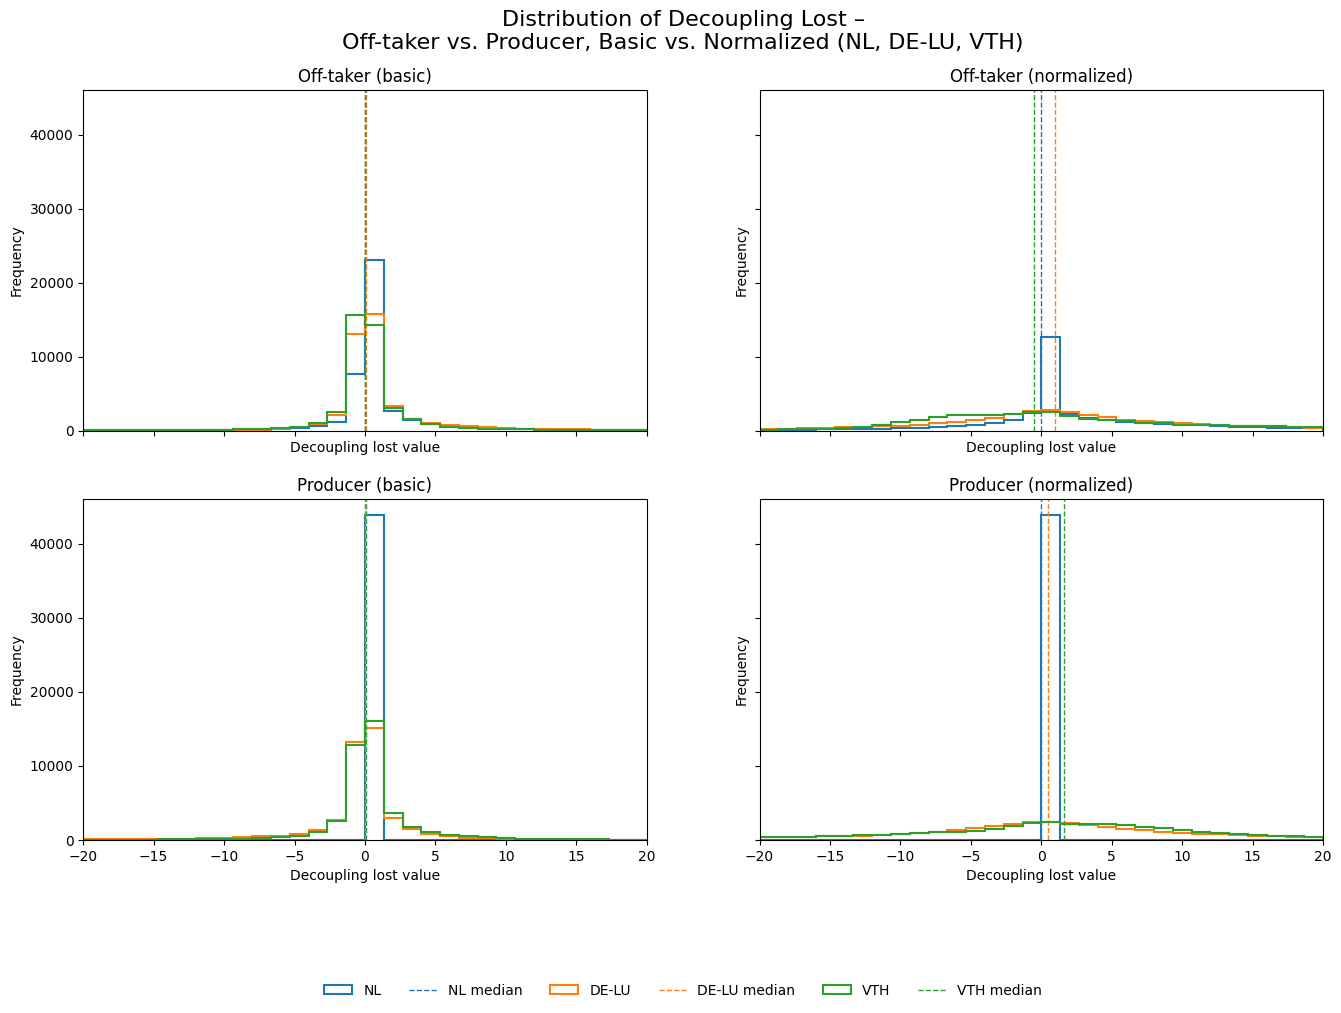

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load CSV
csv_path = '../data/vypocet adapted.csv'
df = pd.read_csv(
    csv_path,
    sep=';',
    skiprows=2,
    header=None,
    decimal=',',
    low_memory=False
)

# 2) Rename columns
variants = ['NL', 'DE-LU', 'VTH']
metrics  = ['FS', 'dec_off', 'dec_off_norm', 'dec_prod', 'dec_prod_norm']
cols = ['id', 'year', 'time'] + [f'{v}_{m}' for v in variants for m in metrics]
df.columns = cols

# 3) Convert decoupling‐lost columns to float
for v in variants:
    for m in ['dec_off','dec_off_norm','dec_prod','dec_prod_norm']:
        df[f'{v}_{m}'] = df[f'{v}_{m}'].astype(float)

# 4) Define plots
plot_specs = [
    ('Off-taker (basic)',      'dec_off'),
    ('Off-taker (normalized)', 'dec_off_norm'),
    ('Producer (basic)',       'dec_prod'),
    ('Producer (normalized)',  'dec_prod_norm'),
]

# 5) Fix x-axis to [-20, 20]
x_min, x_max = -20, 20

# 6) Create common bins
n_bins = 30
bins = np.linspace(x_min, x_max, n_bins + 1)

# 7) Find global max frequency
max_count = 0
for _, col in plot_specs:
    for v in variants:
        data = df[f'{v}_{col}']
        data = data[(data >= x_min) & (data <= x_max)].dropna()
        counts, _ = np.histogram(data, bins=bins)
        max_count = max(max_count, counts.max())

# 8) Plot 2×2 with shared axes, wide figure
colors = ['C0', 'C1', 'C2']
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

handles, labels = [], []
for (title, col), ax in zip(plot_specs, axes.flatten()):
    for var, color in zip(variants, colors):
        series = df[f'{var}_{col}']
        series = series[(series >= x_min) & (series <= x_max)].dropna()
        h = ax.hist(
            series,
            bins=bins,
            density=False,
            histtype='step',
            linewidth=1.5,
            color=color,
            label=var
        )[2]
        median = series.median()
        m = ax.axvline(
            median,
            color=color,
            linestyle='--',
            linewidth=1,
            label=f'{var} median'
        )
        if title == plot_specs[0][0]:
            handles.append(h[0])
            labels.append(var)
            handles.append(m)
            labels.append(f'{var} median')
    ax.set_title(title)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, max_count * 1.05)
    ax.set_xlabel('Decoupling lost value')
    ax.set_ylabel('Frequency')

# 9) Single legend below all subplots
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=6,
    frameon=False,
    fontsize='medium',
    bbox_to_anchor=(0.5, -0.02)
)

# 10) Super-title and layout adjustment
fig.suptitle(
    'Distribution of Decoupling Lost –\n'
    'Off-taker vs. Producer, Basic vs. Normalized (NL, DE-LU, VTH)',
    fontsize=16
)
plt.subplots_adjust(bottom=0.15, top=0.9)
plt.show()

